In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import MDAnalysis as mda
import string

# Cluster analysis for the 8 configurations

In [2]:
from sklearn.cluster import KMeans
from MDAnalysis.analysis.rms import RMSD

In [3]:
rmsd = plumed.read_as_pandas("rmsd.dat")
rtp = plumed.read_as_pandas("rtp_coord.dat")

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3534/2734531026.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  rmsd = plumed.read_as_pandas("rmsd.dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3534/2734531026.py:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  rtp = plumed.read_as_pandas("rtp_coord.dat")


In [18]:
# Select the element below a threshold 
rmsd_cut = []
dist_cut = []
time_cut = []
labels_sim_cut = []
for i in range(12000):
    if rtp["rho"][i] < 1.2:
        rmsd_cut.append(rmsd["rmsd"][i])
        dist_cut.append(rtp["rho"][i])


# Create the "data" needed for clustering
data = []
for i in range(len(rmsd_cut)):
    data.append([rmsd_cut[i], dist_cut[i]])

data = np.array(data)

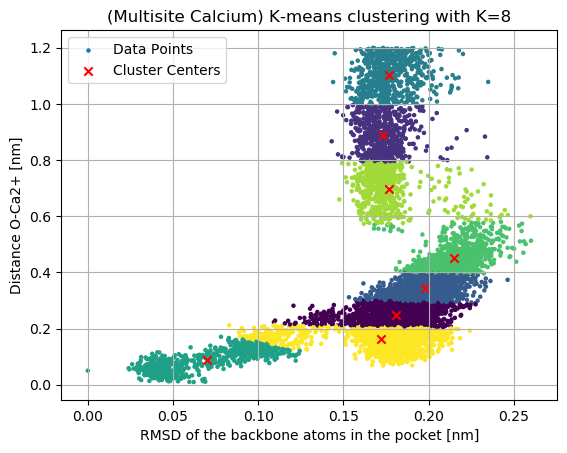

In [23]:
# Specify the number of clusters (K)
num_clusters = 8

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(data)

# Get cluster assignments and cluster centers
labels = kmeans.labels_
# The centers will be important in the remaining part of the notebook
centers = kmeans.cluster_centers_

# Plot the data points and cluster centers
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', s=5, label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', label='Cluster Centers')
plt.title(f'(Multisite Calcium) K-means clustering with K={num_clusters}')
plt.xlabel('RMSD of the backbone atoms in the pocket [nm]')
plt.ylabel('Distance O-Ca2+ [nm]')
plt.legend(loc='upper left')
plt.grid()
plt.savefig("k_clusters_multisite.png")

In [20]:
# Ora la domanda è: come posso rintracciare le configurazioni a partire dai centri?

# Assign each frame of your trajectory to the cluster whose center it is closest to. 
# This step helps categorize the trajectory frames into distinct clusters.

# Compute cluster centers and predict cluster index for each sample

# Take the labels of the previously computed clusters 
labels = kmeans.fit_predict(data)

structures = []

# Identify representative configurations for each cluster
for cluster_label in range(8):

    # I get the positions of the frames belonging to the clusters.
    # cluster_indices changes dimensions during at each iteration of the loop
    cluster_indices = np.where(labels == cluster_label)[0]

    dist = [2]
    min = 1
    for i in range(1, len(cluster_indices)):
        # I take the square of the distances
        # I loop over the set of indices associated to a given cluster
        dist.append((data[cluster_indices][i][0] - centers[cluster_label][0])**2 + (data[cluster_indices][i][1] - centers[cluster_label][1])**2)
        if min > dist[i]:
            min = dist[i]
            ref = cluster_indices[i]

    structures.append(ref)
    #structures.append(np.argmin(dist))

In [21]:
centers

array([[0.18057253, 0.24958885],
       [0.17309401, 0.88981669],
       [0.1978012 , 0.34302567],
       [0.17698969, 1.1035686 ],
       [0.07019057, 0.08905256],
       [0.21483799, 0.45233955],
       [0.17678365, 0.69789945],
       [0.17196689, 0.16327644]])

In [22]:
# List of the frames that have to be dumped from the fitted trajectory with 
# water on the cluster 
structures

#gmx_mpi trjconv -dump 9699 -s md_Meta.tpr -f traj_comp.xtc -o frame_9699.gro

[1557, 6334, 1163, 6716, 339, 6018, 7737, 5300]